In [ ]:
# Imports
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight

import joblib
print("Imports done")



Imports done


In [3]:
# Step 2 — Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
#sample_sub = pd.read_csv("sample_submission.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
display(train.head())

Train shape: (59611, 24)
Test shape: (14900, 23)


,founder_id,founder_age,founder_gender,years_with_startup,founder_role,monthly_revenue_generated,work_life_balance_rating,venture_satisfaction,startup_performance_rating,funding_rounds_led,...,num_dependents,startup_stage,team_size_category,years_since_founding,remote_operations,leadership_scope,innovation_support,startup_reputation,founder_visibility,retention_status
0,8410,31,Male,19,Education,5390.0,Excellent,Medium,Average,2,...,0.0,Mid,Medium,89.0,No,No,No,Excellent,Medium,Stayed
1,64756,59,Female,4,Media,5534.0,Poor,High,Low,3,...,3.0,Mid,Medium,21.0,No,No,No,Fair,Low,Stayed
2,30257,24,Female,10,Healthcare,8159.0,Good,High,Low,0,...,3.0,Mid,Medium,74.0,No,No,No,Poor,Low,Stayed
3,65791,36,Female,7,Education,3989.0,Good,High,High,1,...,2.0,Mid,Small,50.0,Yes,No,No,Good,Medium,Stayed
4,65026,56,Male,41,Education,4821.0,NaN,NaN,Average,0,...,0.0,Senior,Medium,68.0,No,No,No,Fair,Medium,Stayed


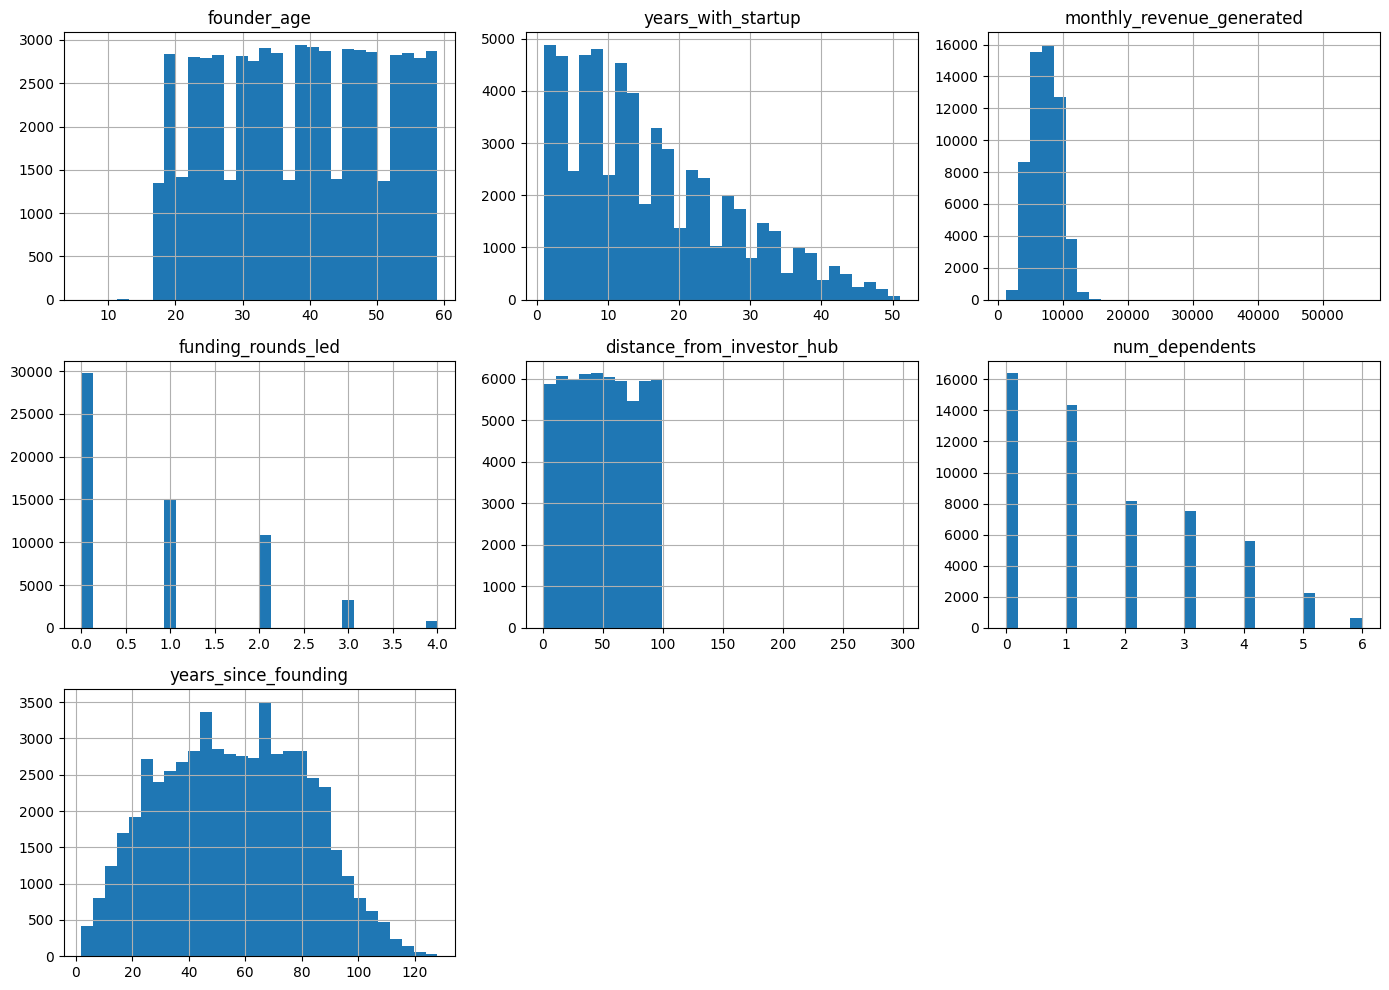

In [10]:
X_numeric = X.select_dtypes(include=['int64','float64'])

X_numeric.hist(figsize=(14,10), bins=30)
plt.tight_layout()
plt.show()


In [ ]:
# prepare X, y, label-encode target, and train/validation split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

TARGET = "retention_status"
IDCOL = "founder_id"

if TARGET not in train.columns:
    raise KeyError(f"Target column '{TARGET}' not found in train columns: {list(train.columns)[:30]}")
print("Target found. ID column in train?", IDCOL in train.columns, " ID in test?", IDCOL in test.columns)

X = train.drop(columns=[TARGET], errors="ignore").drop(columns=[IDCOL], errors="ignore")
y_raw = train[TARGET].copy()

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y_raw)
joblib.dump(le_target, "/content/label_encoder_target.joblib")
print("Saved label encoder to /content/label_encoder_target.joblib")
print("Classes:", list(le_target.classes_))

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Shapes -> X_train:", X_train.shape, "X_val:", X_val.shape, "y_train:", y_train.shape, "y_val:", y_val.shape)


Target found. ID column in train? True  ID in test? True
Saved label encoder to /content/label_encoder_target.joblib
Classes: ['Left', 'Stayed']
Shapes -> X_train: (47688, 22) X_val: (11923, 22) y_train: (47688,) y_val: (11923,)


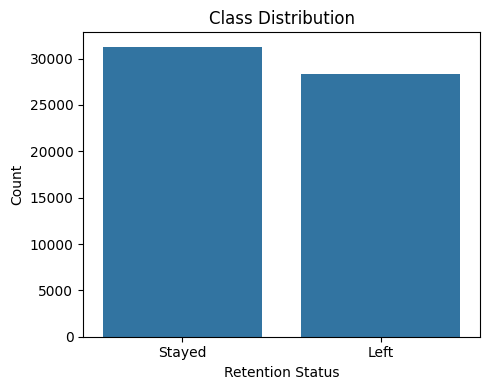

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.countplot(x=y_raw)
plt.title("Class Distribution")
plt.xlabel("Retention Status")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

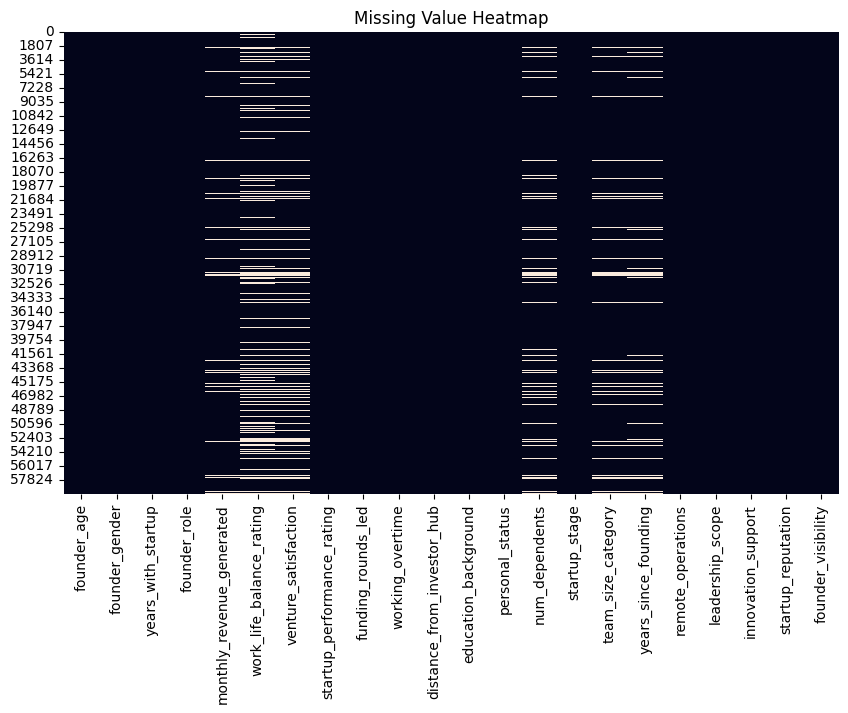

In [8]:
plt.figure(figsize=(10,6))
sns.heatmap(X.isnull(), cbar=False)
plt.title("Missing Value Heatmap")
plt.show()

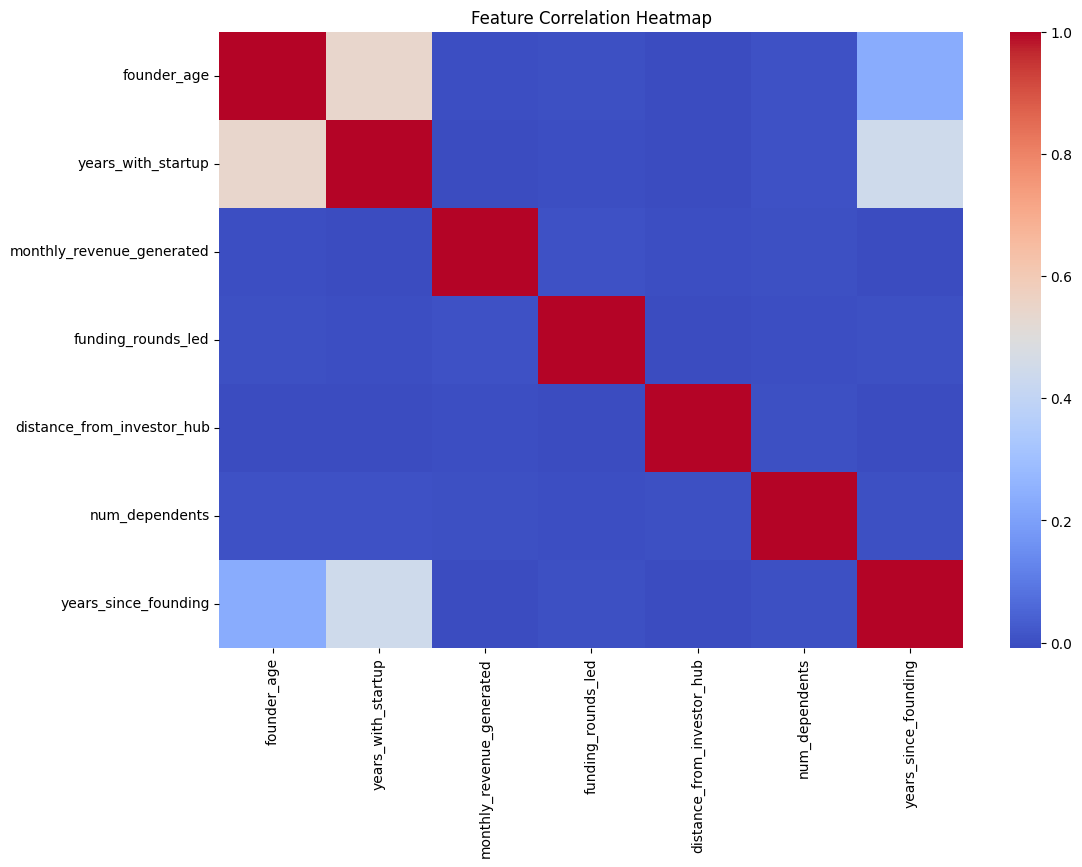

In [9]:
plt.figure(figsize=(12,8))
corr = X.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
# robust pipeline where TargetEncoder gets a DataFrame
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import category_encoders as ce
import numpy as np

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print("cat_cols:", len(cat_cols), "num_cols:", len(num_cols))

pipe_te_df = Pipeline([
    ("targ_enc", ce.TargetEncoder(cols=cat_cols, smoothing=0.2)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),

    ("clf", SVC(kernel="rbf", probability=False, random_state=42))
])

pipe_te_df  


cat_cols: 15 num_cols: 7


,steps,"[('targ_enc', ...), ('imputer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,verbose,0
,cols,"['founder_gender', 'founder_role', ...]"
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,min_samples_leaf,20


In [ ]:
# optional sampling to speed tuning. Change SAMPLE_FRAC as needed.
SAMPLE_FRAC = 1.0  
if SAMPLE_FRAC < 1.0:
    X_train_sample = X_train.sample(frac=SAMPLE_FRAC, random_state=42)
    y_train_sample = y_train[X_train_sample.index]
    print("Using sampled training set:", X_train_sample.shape)
else:
    X_train_sample = X_train
    y_train_sample = y_train
    print("Using full training set:", X_train_sample.shape)

Using full training set: (47688, 22)


In [14]:
# Logistic Regression 

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


y_lr = y_encoded 

X_train_full, X_val, y_train_full, y_val = train_test_split(
    X, y_lr,
    test_size=0.2,
    stratify=y_lr,
    random_state=42
)
print("Train full:", X_train_full.shape, " Val:", X_val.shape)

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric cols:", len(num_cols), "Categorical cols:", len(cat_cols))

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ],
    remainder="drop"
)

logreg = LogisticRegression(
    max_iter=1000,
    multi_class="auto",
    n_jobs=1
)

logreg_full_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", logreg)
])

print("\n Training Logistic Regression on full train split...")
logreg_full_pipe.fit(X_train_full, y_train_full)

y_val_pred_full = logreg_full_pipe.predict(X_val)
acc_lr_full = accuracy_score(y_val, y_val_pred_full)
print(f" Logistic Regression (100% train) val accuracy: {acc_lr_full:.4f}")


Train full: (47688, 22)  Val: (11923, 22)
Numeric cols: 7 Categorical cols: 15

 Training Logistic Regression on full train split...
 Logistic Regression (100% train) val accuracy: 0.7460


C:\Users\satma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [15]:
# Preprocess X for Keras

import numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric cols:", len(num_cols), "Categorical cols:", len(cat_cols))

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

pre_keras = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ],
    remainder='drop'
)

pre_keras.fit(X)

X_all = pre_keras.transform(X) 
X_test_all = pre_keras.transform(test.drop(columns=[IDCOL], errors='ignore'))

print("X_all shape:", X_all.shape)
print("X_test_all shape:", X_test_all.shape)

from sklearn.model_selection import train_test_split

X_train_k, X_val_k, y_train_k, y_val_k = train_test_split(
    X_all, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

print("Train split:", X_train_k.shape, "Val split:", X_val_k.shape)

Numeric cols: 7 Categorical cols: 15
X_all shape: (59611, 56)
X_test_all shape: (14900, 56)
Train split: (47688, 56) Val split: (11923, 56)


In [ ]:
#  Simpler Keras MLP + class_weight + threshold tuning

!pip install tensorflow -q

import numpy as np, pandas as pd, joblib
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version:", tf.__version__)
print("Num GPUs available:", len(tf.config.list_physical_devices('GPU')))

input_dim = X_train_k.shape[1]
print("Input dimension:", input_dim)

classes = np.unique(y_encoded)
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_encoded
)
class_weight = {int(c): float(w) for c, w in zip(classes, class_weights_arr)}
print("Class weights:", class_weight)

def build_mlp_model():
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')  
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_mlp_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    keras.callbacks.ReduceLROnPlateau(
        patience=3,
        factor=0.5,
        min_lr=1e-5,
        monitor='val_loss'
    )
]

print("\n Training Keras MLP (with class_weight) on train/val split...")
history = model.fit(
    X_train_k, y_train_k,
    validation_data=(X_val_k, y_val_k),
    epochs=50,
    batch_size=256,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=2
)

print("\n Tuning threshold on validation...")
val_probs = model.predict(X_val_k, verbose=0).ravel()

thresholds = np.linspace(0.35, 0.65, 31) 
best_t = 0.5
best_acc = 0

for t in thresholds:
    preds = (val_probs >= t).astype(int)
    acc = accuracy_score(y_val_k, preds)
    if acc > best_acc:
        best_acc = acc
        best_t = t

print(" Best threshold on val:", best_t)
print(" Best val accuracy:", round(best_acc, 5))

print("\n Retraining same Keras MLP on FULL data...")
model_full = build_mlp_model()

es_full = keras.callbacks.EarlyStopping(
    patience=4,
    restore_best_weights=True,
    monitor='loss'
)

history_full = model_full.fit(
    X_all, y_encoded,
    epochs=len(history.history['loss']),
    batch_size=256,
    class_weight=class_weight,
    callbacks=[es_full],
    verbose=2
)

print("\n Predicting on test...")
test_probs = model_full.predict(X_test_all, verbose=0).ravel()
preds_num = (test_probs >= best_t).astype(int)

preds_str = le_target.inverse_transform(preds_num)

if IDCOL in test.columns:
    ids = test[IDCOL].values
else:
    ids = np.arange(len(preds_str))

submission_keras = pd.DataFrame({
    "founder_id": ids,
    "retention_status": preds_str
})

out_path = "/content/submission_keras_mlp_weighted.csv"
submission_keras.to_csv(out_path, index=False)

joblib.dump(pre_keras, "/content/preprocessor_keras_weighted.joblib")
model_full.save("/content/keras_mlp_weighted.h5")
acc_mlp_full=best_acc
print("\n Submission saved:", out_path)
print(" Preprocessor saved:", "/content/preprocessor_keras_weighted.joblib")
print(" Keras model saved:", "/content/keras_mlp_weighted.h5")
print(" Submission rows:", len(submission_keras))
print(" Used threshold:", best_t)
print(" Used class weights:", class_weight)


In [ ]:
# SVM with same preprocessing

import numpy as np
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# We assume these already exist from your LR cell:
# X_train_full, X_val, y_train_full, y_val, preprocessor

print("Train full:", X_train_full.shape, " Val:", X_val.shape)

# 1) Define SVM model
svm_clf_full = LinearSVC(
    C=1.0,
    class_weight='balanced',   # helps if classes are imbalanced
    max_iter=5000,
    random_state=42
)

# 2) Build pipeline: same preprocessor + SVM
svm_full_pipe = Pipeline([
    ("pre", preprocessor),   # reuse same preprocessing
    ("clf", svm_clf_full)
])

# 3) Train on FULL training split
print("\n Training SVM (LinearSVC) on full train split...")
svm_full_pipe.fit(X_train_full, y_train_full)

# 4) Evaluate on validation set
y_val_pred_svm_full = svm_full_pipe.predict(X_val)
acc_svm_full = accuracy_score(y_val, y_val_pred_svm_full)
print(f"SVM (100% train) val accuracy: {acc_svm_full:.4f}")


Train full: (47688, 22)  Val: (11923, 22)

 Training SVM (LinearSVC) on full train split...
SVM (100% train) val accuracy: 0.7466


In [ ]:
# Train Logistic, SVM, and Keras MLP on 20% of train split

!pip install tensorflow -q

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))
print("Train full:", X_train_full.shape, " Val:", X_val.shape)

X_train_20, _, y_train_20, _ = train_test_split(
    X_train_full, y_train_full,
    train_size=0.2,
    stratify=y_train_full,
    random_state=42
)
print("Train 20%:", X_train_20.shape, " Val (same):", X_val.shape)

logreg_20 = LogisticRegression(
    max_iter=1000,
    multi_class="auto",
    n_jobs=-1
)

logreg_20_pipe = Pipeline([
    ("pre", preprocessor),  
    ("clf", logreg_20)
])

print("\n Training Logistic Regression on 20% of train...")
logreg_20_pipe.fit(X_train_20, y_train_20)

y_val_pred_lr20 = logreg_20_pipe.predict(X_val)
acc_lr_20 = accuracy_score(y_val, y_val_pred_lr20)
print(f"Logistic Regression (20% train) val accuracy: {acc_lr_20:.4f}")

svm_20 = LinearSVC(
    C=1.0,
    class_weight='balanced',
    max_iter=5000,
    random_state=42
)

svm_20_pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", svm_20)
])

print("\n Training SVM (LinearSVC) on 20% of train...")
svm_20_pipe.fit(X_train_20, y_train_20)

y_val_pred_svm20 = svm_20_pipe.predict(X_val)
acc_svm_20 = accuracy_score(y_val, y_val_pred_svm20)
print(f"SVM (20% train) val accuracy: {acc_svm_20:.4f}")


X_train_20_proc = preprocessor.transform(X_train_20)
X_val_proc = preprocessor.transform(X_val)

if hasattr(X_train_20_proc, "toarray"):
    X_train_20_proc = X_train_20_proc.toarray()
    X_val_proc = X_val_proc.toarray()

input_dim = X_train_20_proc.shape[1]
n_classes = len(np.unique(y_train_full))
print("\nKeras MLP input dim:", input_dim, "| n_classes:", n_classes)

# 2) Build multi-class MLP
def build_mlp_multiclass():
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

mlp_20 = build_mlp_multiclass()

callbacks = [
    keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    keras.callbacks.ReduceLROnPlateau(
        patience=3,
        factor=0.5,
        min_lr=1e-5,
        monitor='val_loss'
    )
]

print("\nTraining Keras MLP on 20% of train...")
history_mlp20 = mlp_20.fit(
    X_train_20_proc, y_train_20,
    validation_data=(X_val_proc, y_val),
    epochs=50,
    batch_size=256,
    callbacks=callbacks,
    verbose=2
)

val_probs_mlp20 = mlp_20.predict(X_val_proc, verbose=0)
y_val_pred_mlp20 = np.argmax(val_probs_mlp20, axis=1)
acc_mlp_20 = accuracy_score(y_val, y_val_pred_mlp20)
print(f"Keras MLP (20% train) val accuracy: {acc_mlp_20:.4f}")

print("\n 20% TRAIN PERFORMANCE (same validation set):")
print(f" - Logistic Regression (20%): {acc_lr_20:.4f}")
print(f" - SVM (20%):                {acc_svm_20:.4f}")
print(f" - Keras MLP (20%):          {acc_mlp_20:.4f}")


try:
    print("\n vs 100% TRAIN (if defined):")
    print(f" - LR 100%:   {acc_lr_full:.4f}")
    print(f" - SVM 100%:  {acc_svm_full:.4f}")
    print(f" - MLP 100%:  {acc_mlp_full:.4f}")
except NameError:
    print("\n(100% accuracies not defined in this session; run your full-data cells first if needed.)")


TensorFlow: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Train full: (47688, 22)  Val: (11923, 22)
Train 20%: (9537, 22)  Val (same): (11923, 22)

 Training Logistic Regression on 20% of train...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression (20% train) val accuracy: 0.7455

 Training SVM (LinearSVC) on 20% of train...
SVM (20% train) val accuracy: 0.7440

Keras MLP input dim: 56 | n_classes: 2

Training Keras MLP on 20% of train...
Epoch 1/50
38/38 - 6s - 161ms/step - accuracy: 0.6337 - loss: 0.6375 - val_accuracy: 0.7247 - val_loss: 0.5457 - learning_rate: 1.0000e-03
Epoch 2/50
38/38 - 0s - 6ms/step - accuracy: 0.7141 - loss: 0.5477 - val_accuracy: 0.7385 - val_loss: 0.5105 - learning_rate: 1.0000e-03
Epoch 3/50
38/38 - 0s - 6ms/step - accuracy: 0.7322 - loss: 0.5228 - val_accuracy: 0.7428 - val_loss: 0.5051 - learning_rate: 1.0000e-03
Epoch 4/50
38/38 - 0s - 7ms/step - accuracy: 0.7309 - loss: 0.5167 - val_accuracy: 0.7437 - val_loss: 0.5035 - learning_rate: 1.0000e-03
Epoch 5/50
38/38 - 0s - 6ms/step - accuracy: 0.7384 - loss: 0.5085 - val_accuracy: 0.7439 - val_loss: 0.5010 - learning_rate: 1.0000e-03
Epoch 6/50
38/38 - 0s - 7ms/step - accuracy: 0.7492 - loss: 0.4991 - val_accuracy: 0.7435 - val_lo